In [1]:
!pip install numpy statsmodels matplotlib seaborn pandas scikit-learn

In [11]:
from sklearn import datasets
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from scipy.stats import binom, norm

In [31]:
def sample_mixture(size=10, loc_1=0, scale_1=1, loc_2=2, scale_2=4, alpha=0.05, delta=0):
  # if 1, then sample from the second distribution;
  # so, we sample from the second distribution with probability (1-alpha)
  sample = []
  mask = []
  which_population = binom.rvs(n=1, p=1-alpha, size=size)
  for population_index in which_population:
    if population_index == 0:
      sample.append(norm.rvs(size=1, loc=loc_1, scale=scale_1)[0])
      mask.append(0)
    else:
      sample.append(norm.rvs(size=1, loc=loc_2, scale=scale_2)[0])
      mask.append(1)
  return np.array(sample) + delta, np.array(mask)


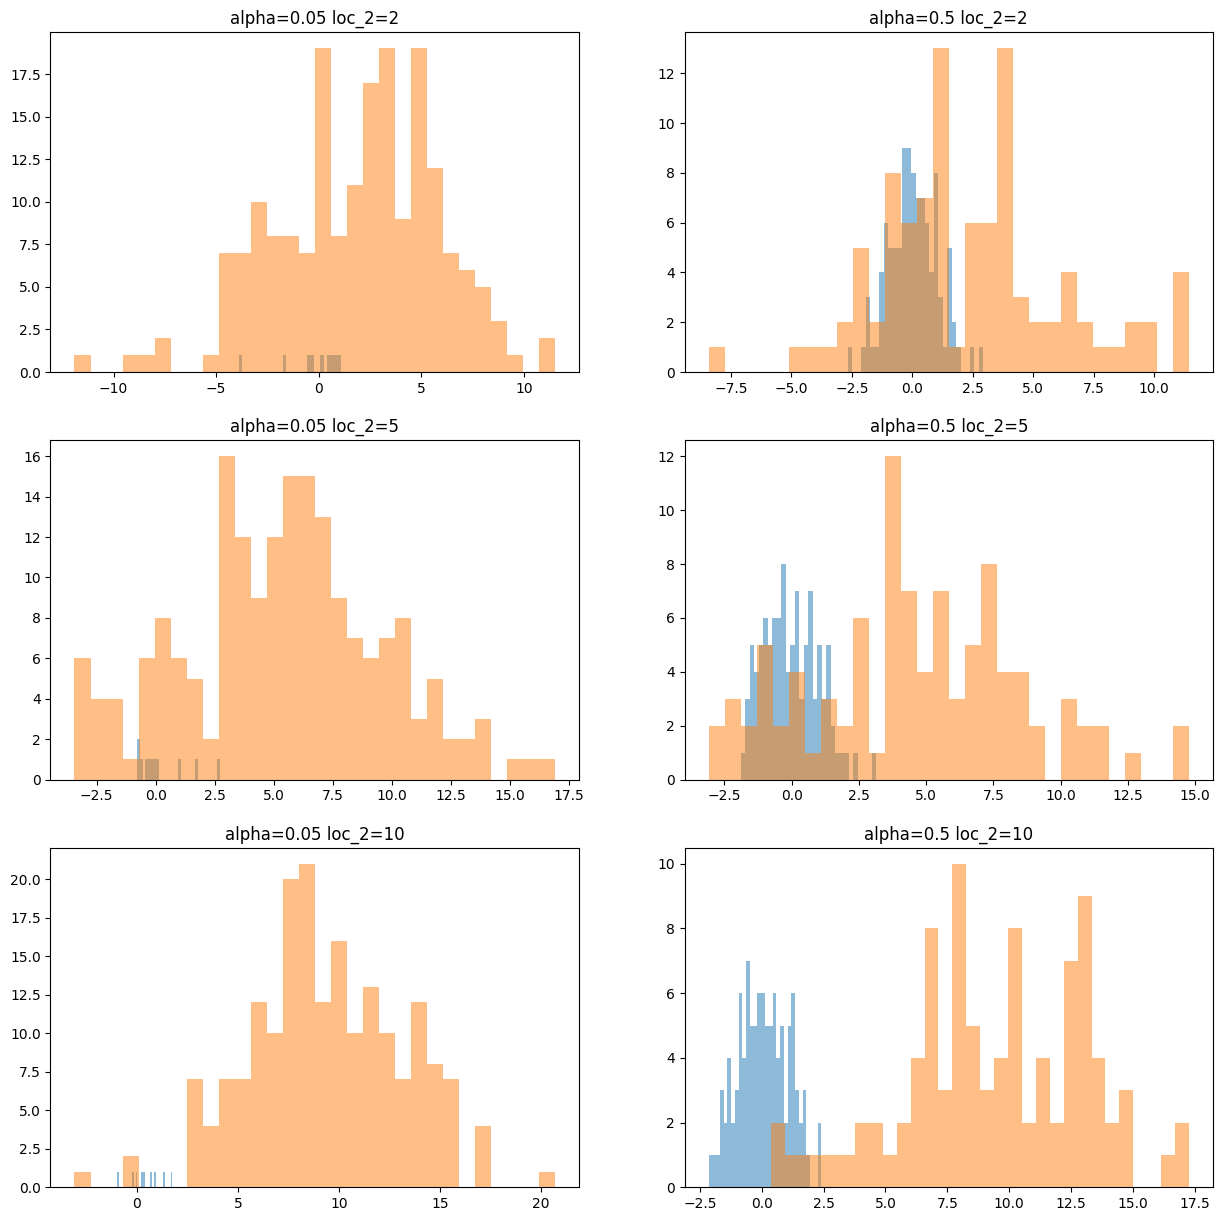

In [32]:
f, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.ravel()
for ax, alpha, loc_2 in zip(axs, [0.05, 0.5, 0.05, 0.5, 0.05, 0.5], [2,2,5,5,10,10]):
  sample, mask = sample_mixture(size=200, loc_2=loc_2, alpha=alpha)
  ax.hist(sample[mask==0], bins=30, alpha=0.5)
  ax.hist(sample[mask==1], bins=30, alpha=0.5)
  ax.set_title(f"alpha={alpha} loc_2={loc_2}")

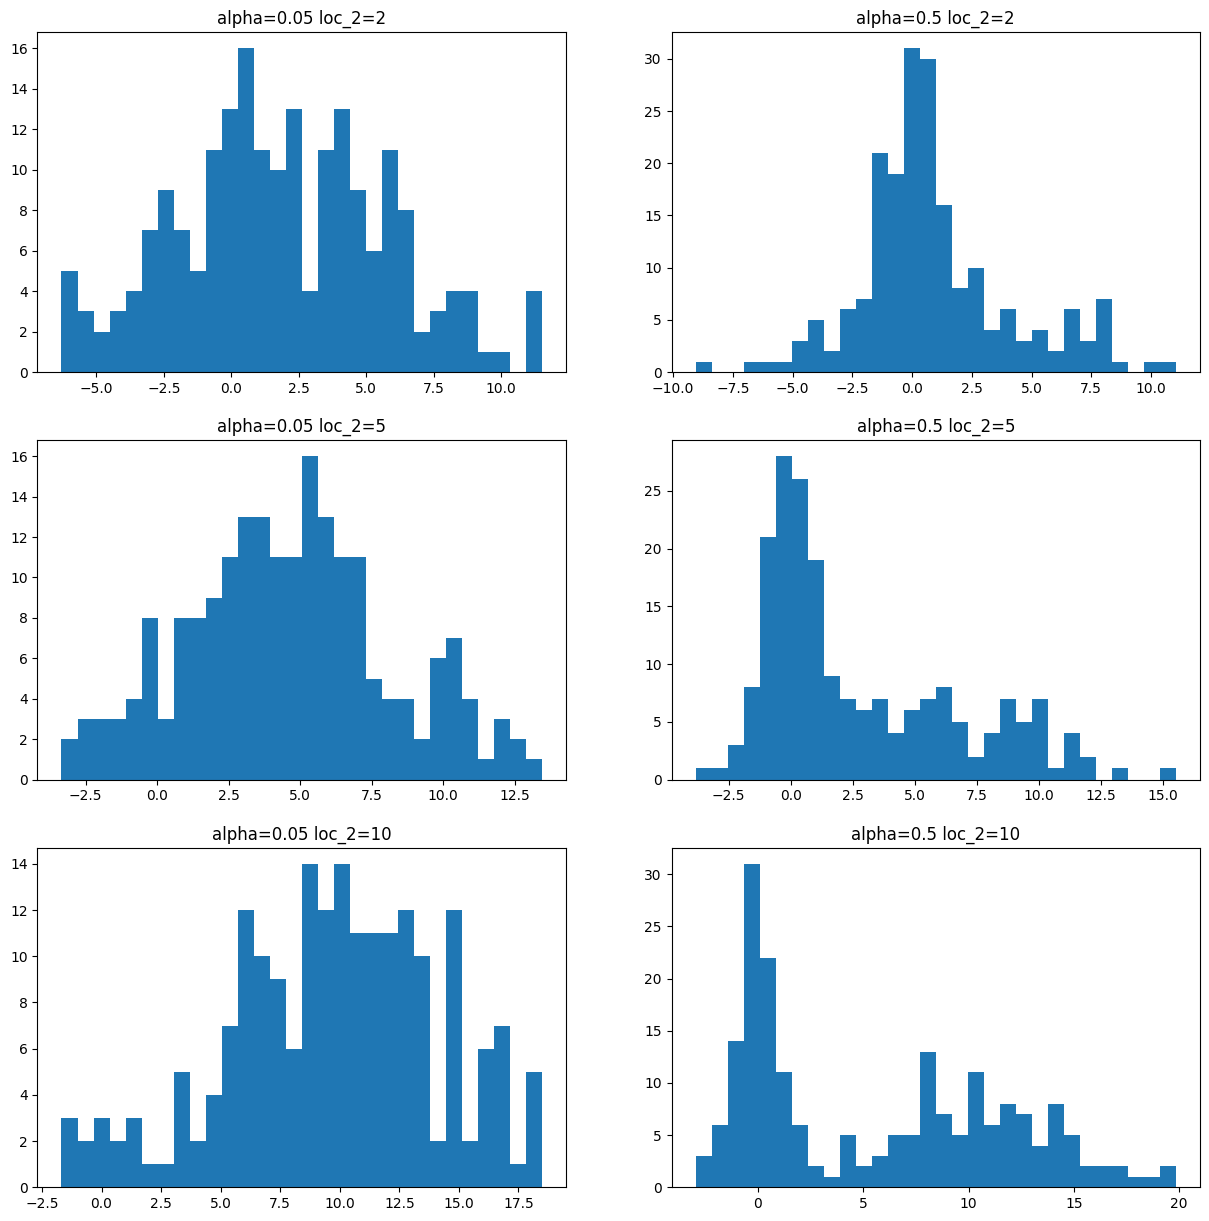

In [30]:
f, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.ravel()
for ax, alpha, loc_2 in zip(axs, [0.05, 0.5, 0.05, 0.5, 0.05, 0.5], [2,2,5,5,10,10]):
  sample, _ = sample_mixture(size=200, loc_2=loc_2, alpha=alpha)
  ax.hist(sample, bins=30)
  ax.set_title(f"alpha={alpha} loc_2={loc_2}")

In [74]:
from tqdm.auto import tqdm

N_exp = 50
sample_size = 30
significance_level = 0.05

alphas = np.linspace(0.01, 1, num=30)
deltas = np.linspace(0, 5, num=30)
rejection_proportions = []
for alpha in tqdm(alphas):
  for delta in deltas:
    rejection_proportions.append(0)
    for _ in range(N_exp):
      sample_1, _ = sample_mixture(size=sample_size, alpha=alpha)
      sample_2, _ = sample_mixture(size=sample_size, alpha=alpha, delta=delta)
      rejection_proportions[-1] += int(wilcoxon(sample_1, sample_2).pvalue < significance_level) / N_exp

  0%|          | 0/30 [00:00<?, ?it/s]

In [51]:
# from itertools import product
# alphas_ = [pair[0] for pair in list(product(alphas, deltas))]
# deltas_ = [pair[1] for pair in list(product(alphas, deltas))]
# values_ = rejection_proportions
# viz = pd.DataFrame({"alpha": alphas_, "delta": deltas_, "value": values_})

In [75]:
values = []
i = 0
for alpha in alphas:
  values.append([])
  for delta in deltas:
    values[-1].append(rejection_proportions[i])
    i += 1
assert i == len(rejection_proportions)
viz = pd.DataFrame(values, columns = deltas.round(2), index=alphas.round(2))

Text(50.722222222222214, 0.5, 'alpha')

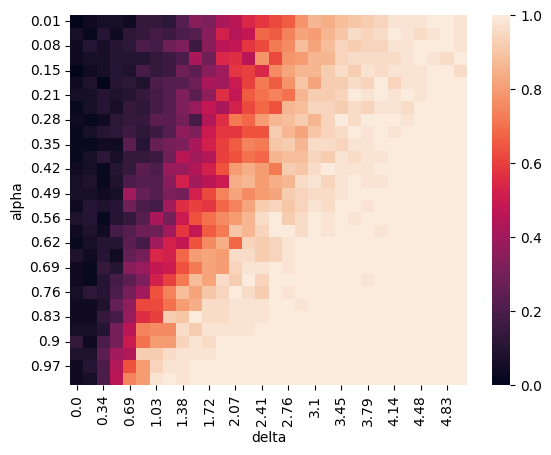

In [77]:
ax = sns.heatmap(viz)
ax.set_xlabel("delta")
ax.set_ylabel("alpha")

Text(0.5, 1.0, 'Консервативность критерия при n=30 с оценкой по 100 итерациям при разных alpha')

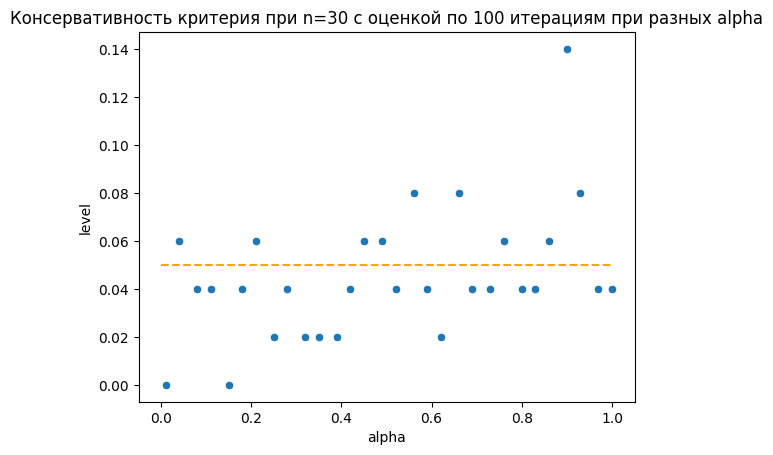

In [93]:
ax = sns.scatterplot(
    data=viz.iloc[:, 0].reset_index().rename(columns={"index": "alpha", 0.0: "level"}),
    x="alpha",
    y="level"
)
ax.plot([0,1], [0.05, 0.05], ls='--', c="orange")
ax.set_title("Консервативность критерия при n=30 с оценкой по 100 итерациям при разных alpha")

На картинках представлены:

- мощность критерия (при $\delta \ne 0$)
- консервативность критерия (при $\delta = 0$, то есть когда медианы выборок действительно совпадают) (подробнее на картинке 2).

Мы замечаем:

- Чем больше $\delta$, тем лучше две выборки резделены, тем проще опровергнуть гипотезу о равенстве медиан.
- Мощность критерия увеличивается при $\alpha\rightarrow1$
Это связано с тем, что при больших alpha выборка имеет меньший разброс, значит проще отделить

In [97]:
from tqdm.auto import tqdm

rejection_proportions_with_lower_second_scale = []
for alpha in tqdm(alphas):
  for delta in deltas:
    rejection_proportions_with_lower_second_scale.append(0)
    for _ in range(N_exp):
      sample_1, _ = sample_mixture(size=sample_size, alpha=alpha, scale_2=1)
      sample_2, _ = sample_mixture(size=sample_size, alpha=alpha, delta=delta, scale_2=1)
      rejection_proportions_with_lower_second_scale[-1] += int(wilcoxon(sample_1, sample_2).pvalue < significance_level) / N_exp

  0%|          | 0/30 [00:00<?, ?it/s]

In [98]:
values = []
i = 0
for alpha in alphas:
  values.append([])
  for delta in deltas:
    values[-1].append(rejection_proportions_with_lower_second_scale[i])
    i += 1
assert i == len(rejection_proportions_with_lower_second_scale)
viz_with_lower_second_scale = pd.DataFrame(values, columns = deltas.round(2), index=alphas.round(2))

Text(50.722222222222214, 0.5, 'alpha')

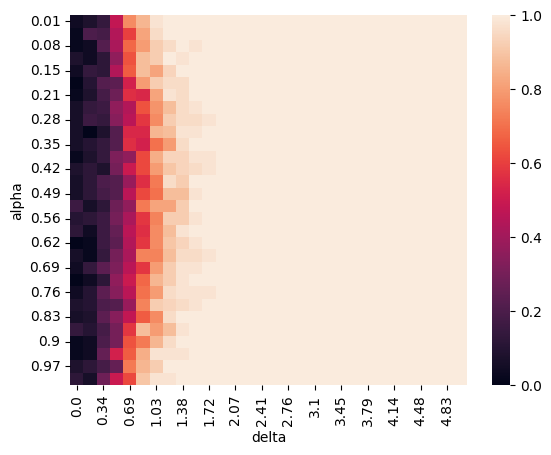

In [99]:
ax = sns.heatmap(viz_with_lower_second_scale)
ax.set_xlabel("delta")
ax.set_ylabel("alpha")

При уменьшении разброса, мощность критерия вырастает и alpha уже не влияет.